# Data Preprocessing

## Polar Sea Ice Prediction

###Readme:

For all data we have same setup: batch size [12], prediction [30], sliding window: 30 days.

Training testing split: first 37 years of training, last 1 year of testing. 

Data: 1979-2018 (daily records)

- Input Features: 11 -> 
       'Day', 'wind_10m', 'specific_humidity', 'LW_down', 'SW_down','rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent'
- Output Predictand: 'sea_ice_extent monthly mean'
- 14,610 records for 39 years ~ 374 records/year 
- Look-up window: 1 month ~ 30 timesteps
- Batch size: 12 

## Initial Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install attention

     |████████████████████████████████| 462 kB 8.3 MB/s 


In [3]:
import os
import math
from math import sqrt
import glob
import numpy as np
from numpy.random import seed
import csv
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed
from tensorflow.keras.models import load_model, Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from attention import Attention

seed_number = 1
seed(seed_number)

## Sea Ice Prediction - LSTM

## Loading Combined Data 1979-2018

Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall',  'sst', 't2m', 'surface_pressure','sea_ice_extent'




In [4]:
# Define paths to load data
path = '/content/drive/MyDrive/SYDE 675/Project/Data'
data_path = path + '/dailyt30_features.npy'
target_path = path + '/dailyt30_target.npy'

data = np.load(data_path, allow_pickle=True)
target = np.load(target_path, allow_pickle=True)

In [5]:
print("Shape of data = ", data.shape)
print("Shape of target data = ", target.shape)

Shape of data =  (480, 30, 11)
Shape of target data =  (480,)


In [6]:
# Adding a lag of 1 month to targets
lag = 1
data = data[:-lag, :, :]
target = target[lag:]

print(data.shape)
print(target.shape)

(479, 30, 11)
(479,)


### Preprocess the data
LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. 

## Train Test Split

In [7]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) # total number of pixels

NUM_TRAIN = LEN_DATA - (60) # last 5 years for validations
NUM_TEST = LEN_DATA - NUM_TRAIN

print(f'{LEN_DATA}')
print(f'{NUM_TRAIN}')
print(f'{NUM_TEST}')

x_train = data[ : NUM_TRAIN]
x_test = data[NUM_TRAIN : ]

# Split features and labels
y_train = target[ : NUM_TRAIN] # target is last column i-e sea-ice
y_test = target[NUM_TRAIN : ] # target is last column i-e sea-ice

479
419
60


In [8]:
print(f'{x_train.shape}')
print(f'{y_train.shape}')
print(f'{x_test.shape}')
print(f'{y_test.shape}')

(419, 30, 11)
(419,)
(60, 30, 11)
(60,)


## Reshaping Input and Target Features

In [9]:
# Convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    print(f'Converted from shape {dataset.shape} to shape {X.shape}')
    return X

## Normalization


In [10]:
# Normalize the features
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2])) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[2])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling

In [11]:
timesteps = 30
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model

Converted from shape (12570, 11) to shape (419, 30, 11)
Converted from shape (1800, 11) to shape (60, 30, 11)


In [12]:
print(f'{x_train.shape}')
print(f'{y_train.shape}')
print(f'{x_test.shape}')
print(f'{y_test.shape}')

(419, 30, 11)
(419, 1)
(60, 30, 11)
(60, 1)


# LSTM Network

In [13]:
timestep = timesteps
features = 11  # Original notebook had 10, but it should be 11

model_input = Input(shape=(timestep,features))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
#x = LSTM(32, return_sequences=False)(x)
x = LSTM(16, return_sequences=True)(x)

# Add attention layer
x = Attention(trainable = True)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x, name='dLSTM')

print(model.summary())

Model: "dLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 11)]          0         
                                                                 
 lstm (LSTM)                 (None, 30, 64)            19456     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 30, 16)            3136      
                                                                 
 attention (Attention)       (None, 128)               4352      
                                                                 
 dense (Dense)               (None, 32)                4128  

# Model Training

In [58]:
for i in range(20):
  model = Model(model_input, x)

  # Compiling the network
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(x_train, y_train, epochs=100, batch_size=12, verbose=0, shuffle=True)

  trainPred = model.predict(x_train)
  testPred = model.predict(x_test)

  # Reverting data back to 2D from 3D
  x_train_t = x_train.reshape(-1, x_train.shape[2])
  x_test_t = x_test.reshape(-1, x_test.shape[2])

  # Invert scaling for forecasted values 
  inv_trainPred = scaler_l.inverse_transform(trainPred)
  inv_testPred = scaler_l.inverse_transform(testPred)

  # Invert scaling for actual values
  inv_y_train = scaler_l.inverse_transform(y_train)
  inv_y_test = scaler_l.inverse_transform(y_test)

  rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))

  # calculate Normalized RMSE
  y_max = inv_y_test.max()
  y_min = inv_y_test.min()
  nrmse = rmse /(inv_y_test.mean()) 

  r_sq = r2_score(inv_y_test, inv_testPred)

  file_path = '/content/drive/MyDrive/SYDE 675/Project/Models/d-LSTM/d-lstm_scores.csv'

  header = ['seed', 'Test RMSE', 'Test normalized RMSE', 'R_Square']

  if os.path.exists(file_path):
    # If file exists, append row
    with open(file_path, 'a', encoding='UTF8') as f:
      writer = csv.writer(f)

      # write the data
      writer.writerow([seed_number, rmse, nrmse, r_sq])

  else:
    # If file does not exist, write new file
    with open(file_path, 'w', encoding='UTF8') as f:
      writer = csv.writer(f)

      # write the header
      writer.writerow(header)

      # write the data
      writer.writerow([seed_number, rmse, nrmse, r_sq])

# Scores in csv files

In [59]:
results = pd.read_csv(file_path)
results.describe()

,seed,Test RMSE,Test normalized RMSE,R_Square
count,20.000000,20.000000,20.000000,20.000000
mean,1.500000,434372.890326,0.041467,0.982856
std,0.512989,34586.787803,0.003302,0.002715
min,1.000000,375727.452161,0.035868,0.976941
25%,1.000000,422864.034529,0.040368,0.981588
50%,1.500000,433619.521045,0.041395,0.983018
75%,2.000000,451510.749400,0.043103,0.983849
max,2.000000,505278.096300,0.048236,0.987250


# Model Predictions

In [60]:
trainPred = model.predict(x_train)
testPred = model.predict(x_test)

print(trainPred.shape)
print(testPred.shape)

(419, 1)
(60, 1)


In [61]:
# Reverting data back to 2D from 3D
x_train_t = x_train.reshape(-1, x_train.shape[2])
x_test_t = x_test.reshape(-1, x_test.shape[2])

print(x_train_t.shape)
print(trainPred.shape)
print(x_test_t.shape)
print(testPred.shape)

(12570, 11)
(419, 1)
(1800, 11)
(60, 1)


In [62]:
# Invert scaling for forecasted values 
inv_testPred = scaler_l.inverse_transform(testPred)
print("Sample of inverted predited values = ", inv_testPred[0])

# Invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test)
print("Sampe of inverted actual values = ", inv_y_test[0])

Sample of inverted predited values =  [14089852.]
Sampe of inverted actual values =  [13629155.9]


In [63]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))
print('Test RMSE: %.3f' % rmse)

# Calculate Normalized RMSE
y_max = y_test.max()
y_min = y_test.min()
nrmse = rmse /(inv_y_test.mean()) 
print('Test NRMSE:', nrmse)

# Calculate R-square
r_sq = r2_score(inv_y_test, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test RMSE: 444212.300
Test NRMSE: 0.042406327353848104
Test R_Square: 0.982


# Plotting

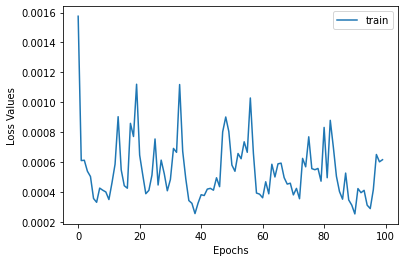

In [64]:
# Plot of training loss
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.show()

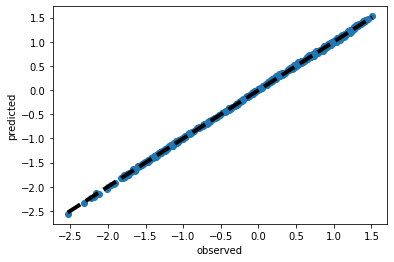

In [66]:
# Scatter plot of predicted and observed values for train set
fig, ax = plt.subplots()
ax.scatter(y_train, trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

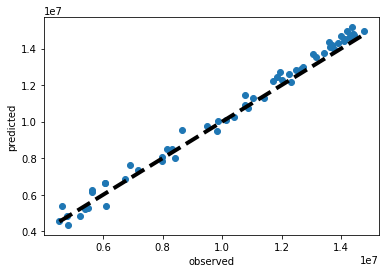

In [68]:
# Scatter plot of predicted and observed values for test set
fig, ax = plt.subplots()
ax.scatter(inv_y_test, inv_testPred) #[:,:,6]
ax.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

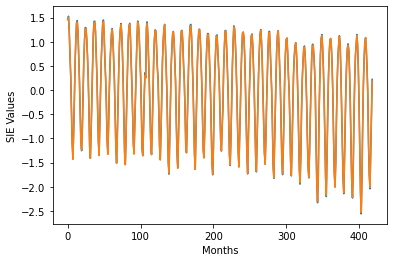

In [71]:
# Plot of observed and predictions for train set
plt.plot(trainPred)
plt.plot(y_train)
plt.xlabel("Months")
plt.ylabel("SIE Values")
plt.show()

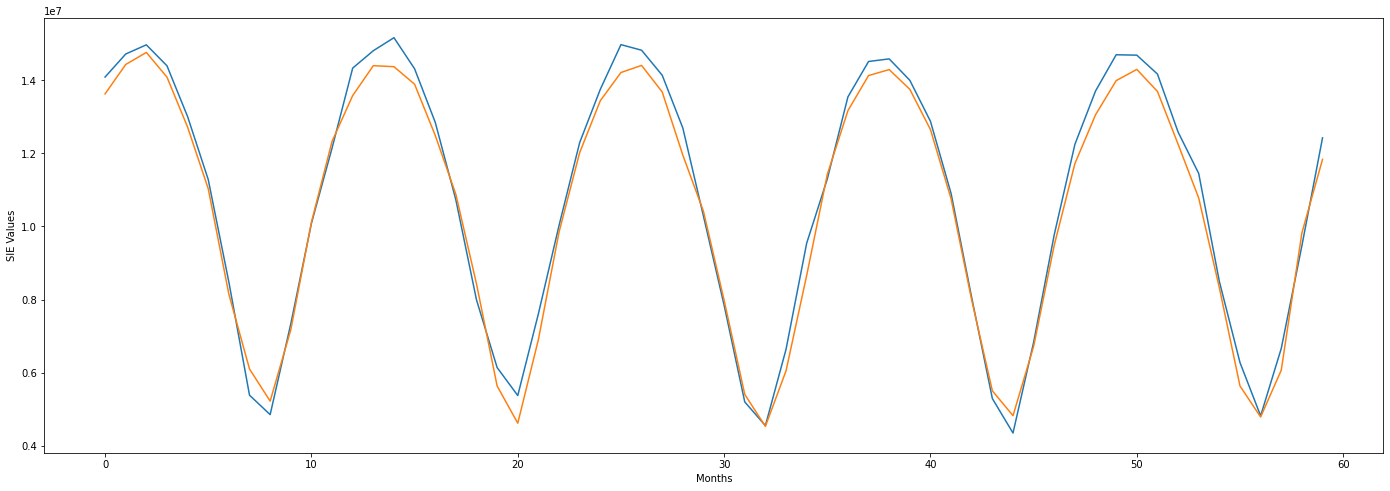

In [73]:
# Plot of observed and predictions for test set
fig, ax = plt.subplots(figsize=(24, 8))
plt.plot(inv_testPred)
plt.plot(inv_y_test)
plt.xlabel("Months")
plt.ylabel("SIE Values")
plt.show()

<BarContainer object of 60 artists>

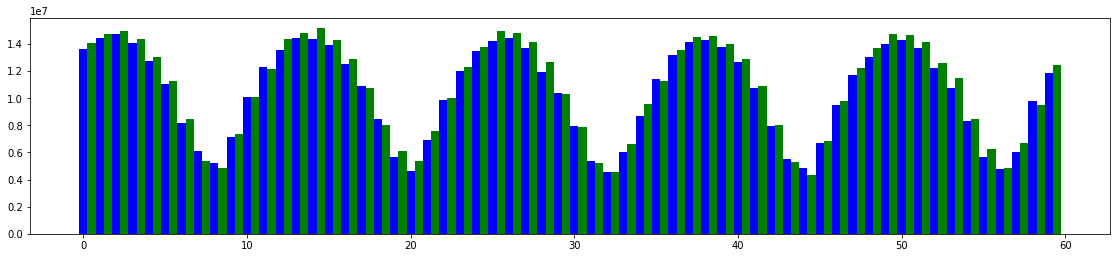

In [74]:
# 1 year's plot
X = np.arange(len(testPred))
fig = plt.figure(figsize=(15, 3))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, inv_y_test.flatten(), color = 'b', width = 0.5)
ax.bar(X + 0.5, inv_testPred.flatten(), color = 'g', width = 0.5)